In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
# import bond_pricing 
import numpy_financial as npf
import bond_pricing as bp

/var/folders/qz/lwgtdmfx4kj1cpw06sz1b21r0000gn/T/ipykernel_13889/4273595620.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/bond_pricing/simple_bonds.py:529: UserWarning: Module isda_daycounters is not installed.
Only 'simple' daycount (basically ACT/365) is available.
To use other daycounts, install isda_daycounters from
https://github.com/miradulo/isda_daycounters
  warn("Module isda_daycounters is not installed.\n"


In [4]:
# import bond closing price data
dataframe = pd.read_csv('bond_close.csv')
# visualize the data:
dataframe
# Let's pick out 10 bonds, and since we want to plot the 5-year Yield curve, we will only use bonds with maturityday before 1/1/2029
# we will also pick bonds evenly distributed with maturity date with half year gap, 
# since government of Canada issues all of its bonds with a semi-annual coupon
dataframe['Maturity Date'] = pd.to_datetime(dataframe['Maturity Date'])
# keep bonds with maturity date before 1/1/2029
dataframe = dataframe[dataframe['Maturity Date'] <= '2029-3-1']
dataframe = dataframe[(dataframe['Maturity Date'].dt.month == 3) | (dataframe['Maturity Date'].dt.month == 9)]
# the bond that matures in March of 2024 is too close to maturity so we choose the other 10. 
dataframe = dataframe[dataframe['Maturity Date'] != '2024-3-1']
dataframe_sorted = dataframe.sort_values(by="Maturity Date")

## Yield Curve

In [5]:

# we have a our clean price in the dataframe
clean_price = dataframe_sorted.iloc[:, 4 : 16]
clean_price

# Create a list of closing dates
lst_date = []
for date in clean_price:
  lst_date.append(date)

# Create a copy of the dataframe for dirty price
dirty_price_df = dataframe_sorted.copy()

# Create a dataframe of dirty prices
for index in dataframe_sorted.index:
  for date in lst_date:
    date_time = pd.to_datetime(date)

    # Currently we have the closing prices as clean price, and we wish to find each bond's last coupon payment date
    clean_price = dataframe_sorted[date][index]
    coupon_rate = float(dataframe_sorted['Coupon'][index].strip('%'))

    # Since coupon payment is paid semi-annually, we have:
    accured_interest = ((date_time - pd.to_datetime(str(date_time.year - 1) + '-09/-1')).days / 365) * coupon_rate
    # Calculate the dirty price:
    new_price = accured_interest + clean_price
    dirty_price_df[date][index] = new_price
dirty_price_df
price_columns = dataframe_sorted.columns.tolist()[-11:]
price_columns

/var/folders/qz/lwgtdmfx4kj1cpw06sz1b21r0000gn/T/ipykernel_13889/2018243846.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dirty_price_df[date][index] = new_price
/var/folders/qz/lwgtdmfx4kj1cpw06sz1b21r0000gn/T/ipykernel_13889/2018243

['2024-01-08',
 '2024-01-09',
 '2024-01-10',
 '2024-01-11',
 '2024-01-12',
 '2024-01-15',
 '2024-01-16',
 '2024-01-17',
 '2024-01-18',
 '2024-01-19',
 '2024-01-22']

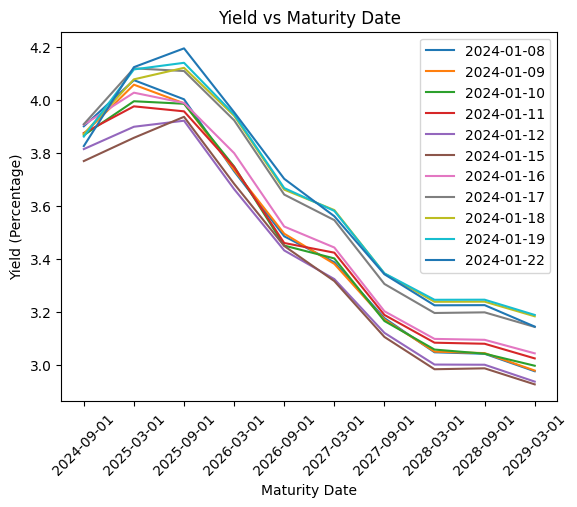

In [6]:
# Calculating ytm
lst_ymt = []

for date in lst_date:
  temp_lst = []
  for index in dirty_price_df.index:
    coupon_rate = float(dirty_price_df['Coupon'][index].strip('%'))
    maturity_date = dirty_price_df['Maturity Date'][index]
    time_to_maturity = (maturity_date - pd.to_datetime(date)).days / 365 
    price = float(dirty_price_df[date][index]) * -1
    ytm = npf.rate(nper = time_to_maturity, pmt = coupon_rate, pv = price, fv = 100)
    temp_lst.append((str(maturity_date.date()), ytm))
  lst_ymt.append((date, temp_lst))
lst_ymt
# now we plot the data
for line in lst_ymt:
  x = [i[0] for i in line[1]]
  y = [i[1] * 100 for i in line[1]]
  plt.plot(x, y, label=line[0])
  plt.xlabel('Maturity Date')
  plt.ylabel('Yield (Percentage)')
  plt.title('Yield vs Maturity Date')
  plt.xticks(rotation=45)
  plt.legend()


## Spot Curve

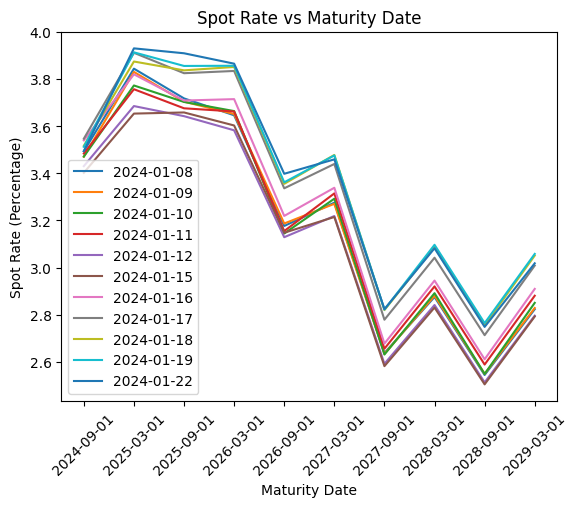

In [40]:
# Using BootStrap Function Template we will calculate the spot rate
# First let's create the list of bonds, which should contain price, coupon rate, and meturity date
lst_bonds = []
for date in lst_date:
  bonds = []
  for index in dirty_price_df.index:
    price = float(dirty_price_df[date][index])
    coupon_rate = float(dirty_price_df['Coupon'][index].strip('%')) / 100
    maturity_date = dirty_price_df['Maturity Date'][index]
    bonds.append((price, coupon_rate, maturity_date))
  lst_bonds.append((date, bonds))
lst_bonds

# Now we have a list of bonds, we need to calculate the spot rates, and we record them in a list
lst_spot_rate =[]
for item in lst_bonds:
    spot_rates = np.zeros(len(item[1]))

    # we get our 1 period bond by indexing
    first_bond = item[1][0]

    # the starting date for this bond is
    start_date = pd.to_datetime(item[0])

    # We calculate the first time period for when we calculate the spot rate for first period bond
    first_time_period = float((first_bond[2] - start_date).days) / 365 

    # we will record each spot rate and its maturity date using a tuple:
    lst_temp = []
    for i, (price, coupon_rate, maturity) in enumerate(item[1]):

      # first we  calculate the number of coupon payments for each bond
      num_payments = (maturity - start_date).days // 365 * 2
      cash_flows = np.array([coupon_rate/2 * 100] * (num_payments - 1) + [100 + coupon_rate * 100/2])
      # now we calculate a list of time periods for the coupon payments 
      time_periods = [first_time_period]+ [first_time_period + (j+1) * 0.5 for j in range(i-1)]

      # now if we have the first bond then we can directly solve the spot rate by following:
      if i == 0:
        spot_rate = - np.log(price/ (coupon_rate * 100 /2  + 100)) / first_time_period

      # otherwise we need to first calculate sum all the present value of the other coupon payments, then subtract it to get residual, then solve for spot rate like follow:
      else:
        time_periods.append((maturity - item[1][i-1][2]).days / 365 + time_periods[-1]) # get the time period for the last cash flow
        time_periods = np.array(time_periods)
        discounted_cash_flows = [cf * np.exp(- spot_rates[j] * time_periods[j] ) for j, cf in enumerate(cash_flows[:-1])]
        discounted_cash_flows = np.sum(discounted_cash_flows) # this is everything except the last cash flow
        residual = price - discounted_cash_flows
        
        # If the residual is too small then we us ethe previous spot rate as an approximation
        if residual <= 0:
          print(f"Warning: Residual for bond with maturity {maturity} is too low. Adjusting spot rate calculation.")
          spot_rate = spot_rates[i-1] 
        
      # otherwise we can directly calculate the spot rate like follow:
        else:
          spot_rate = np.log(residual/ (coupon_rate * 100 /2  + 100)) * - 1 / time_periods[-1]
      spot_rates[i] = spot_rate
      lst_temp.append((str(maturity.date()), spot_rate))
    lst_spot_rate.append((str(start_date.date()), lst_temp))

# This is our final list of spot rates
lst_spot_rate

# let's graph the spor rates:

for line in lst_spot_rate:
  x = [i[0] for i in line[1]]
  y = [i[1] * 100 for i in line[1]]
  plt.plot(x, y, label=line[0])
  plt.xlabel('Maturity Date')
  plt.ylabel('Spot Rate (Percentage)')
  plt.title('Spot Rate vs Maturity Date')
  plt.xticks(rotation=45)
  plt.legend()




## Forward Curve: